In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2)


In [3]:
train_left = pd.read_csv('./train/train.query.tsv',sep='\t',header=None)
train_left.columns=['id','q1']
train_right = pd.read_csv('./train/train.reply.tsv',sep='\t',header=None)
train_right.columns=['id','id_sub','q2','label']
train_df = train_left.merge(train_right, how='left')
train_df['q2'] = train_df['q2'].fillna('好的')
test_left = pd.read_csv('./test/test.query.tsv',sep='\t',header=None, encoding='gbk')
test_left.columns = ['id','q1']
test_right =  pd.read_csv('./test/test.reply.tsv',sep='\t',header=None, encoding='gbk')
test_right.columns=['id','id_sub','q2']
test_df = test_left.merge(test_right, how='left')


# 观察训练和测试数据的前几行

In [4]:
train_df.head(5)

,id,q1,id_sub,q2,label
0,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
1,0,采荷一小是分校吧,1,是的,0
2,0,采荷一小是分校吧,2,这是5楼,0
3,1,毛坯吗？,0,因为公积金贷款贷的少,0
4,1,毛坯吗？,1,是呢,0


In [5]:
test_df.head(5)

,id,q1,id_sub,q2
0,0,东区西区？什么时候下证？,0,我在给你发套
1,0,东区西区？什么时候下证？,1,您看下我发的这几套
2,0,东区西区？什么时候下证？,2,这两套也是金源花园的
3,0,东区西区？什么时候下证？,3,价钱低
4,0,东区西区？什么时候下证？,4,便宜的房子，一般都是顶楼


## 我们能看到数据的字段包含微博id，微博发布时间，微博中文内容，微博图片，微博视频 和情感倾向(标签)

In [6]:
train_df.shape, test_df.shape

((21585, 5), (53757, 4))

In [7]:
df=pd.concat([train_df,test_df],sort=False)

## 多标签

Text(0.5, 1.0, 'label')

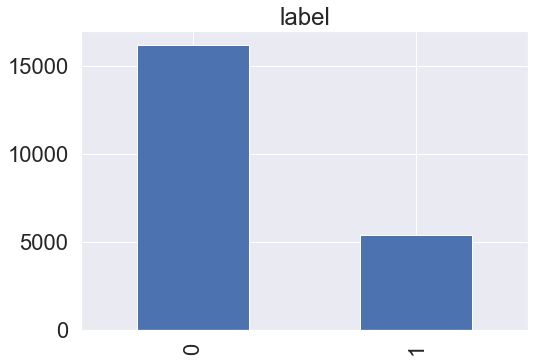

In [8]:
train_df['label'].value_counts().plot.bar()
plt.title('label')

# 数据清洗

from bs4 import BeautifulSoup
def beautifulSoup(html):
    soup = BeautifulSoup(html,'html.parser')
    return soup.get_text()

df['Question Sentence'] = df['Question Sentence'].apply(beautifulSoup) # applymap()则作用于DataFrame中的每一个元素

In [13]:
import re
def htmlClean(text):
    re_tag = re.compile('im=new Image;im.src.*";')  # HTML标签
    new_text = re.sub(re_tag, '', text)
    return new_text
 
        

df['Question Sentence'] = df['Question Sentence'].apply(htmlClean) # applymap()则作用于DataFrame中的每一个元素

# 替换中英文字符
import re
def replace_punctuation(example):
    example = list(example)
    pre = ''
    cur = ''
    for i in range(len(example)):
        if i == 0:
            pre = example[i]
            continue
        pre = example[i-1]
        cur = example[i]
        if re.match("[\w]", pre): # pre是中文、数字、字母
            if re.match("[\w]", cur): # cur是中文、数字、字母
                continue
            elif cur == ',':
                example[i] = '，'
            elif cur == '.':
                example[i] = '。'
            elif cur == '?':
                example[i] = '？'
            elif cur == ':':
                example[i] = '：'
            elif cur == ';':
                example[i] = '；'
            elif cur == '!':
                example[i] = '！'
            elif cur == '"':
                example[i] = '”'
            elif cur == "'":
                example[i] = "’"
        else: # pre非中文、数字、字母
            if not re.match("[\w]", cur): # cur非中文、数字、字母
                example[i] = ''
    return ''.join(example)

df['Question Sentence'] = df['Question Sentence'].apply(replace_punctuation) # applymap()则作用于DataFrame中的每一个元素

r1 = "[a-zA-Z'!\"#$%&'()*+,-./:;<=>?@★[\\]^_`{|}~]+"
comment = []
for com_str in df['Question Sentence']:
    com_str = re.sub(r1,'',com_str) # 非法字符替换为空
    com_str = com_str.replace("病情描述：","")
    com_str = com_str.strip()
    if not com_str:
        com_str = '无'
    comment.append(com_str)
    
df['Question Sentence'] = comment


In [9]:
df['q1_len'] = df['q1'].astype(str).apply(len)
df['q2_len'] = df['q2'].astype(str).apply(len)

In [10]:
train_df = df[:len(train_df)]
test_df = df[len(train_df):]



<AxesSubplot:xlabel='q1_len', ylabel='Density'>

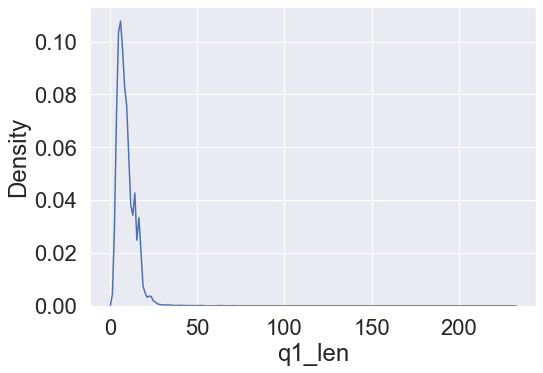

In [11]:
sns.kdeplot(df['q1_len'])
#plt.title('weibo_len')

<AxesSubplot:xlabel='q1_len', ylabel='Density'>

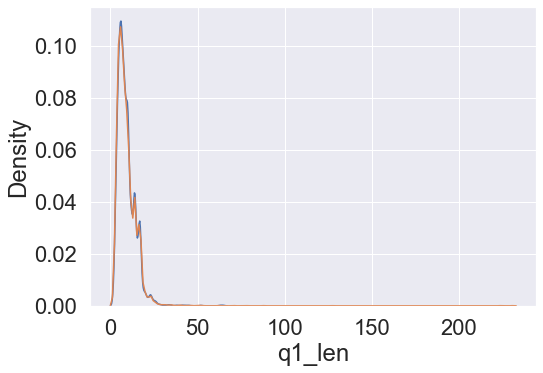

In [12]:
sns.kdeplot(train_df['q1_len'])
sns.kdeplot(test_df['q1_len'])

<AxesSubplot:xlabel='q1_len', ylabel='Density'>

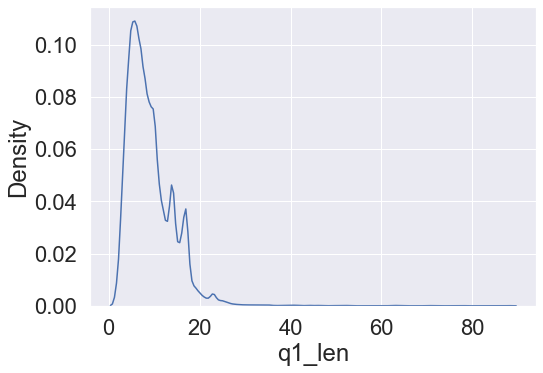

In [13]:
x = df.loc[df["q1_len"]<100]
sns.kdeplot(x['q1_len'])

<AxesSubplot:xlabel='q2_len', ylabel='Density'>

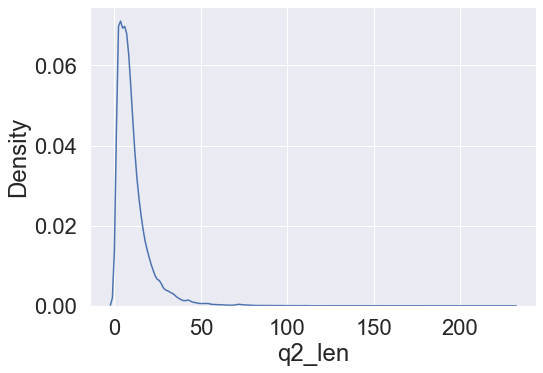

In [24]:
sns.kdeplot(df['q2_len'])
#plt.title('weibo_len')

<AxesSubplot:xlabel='q2_len', ylabel='Density'>

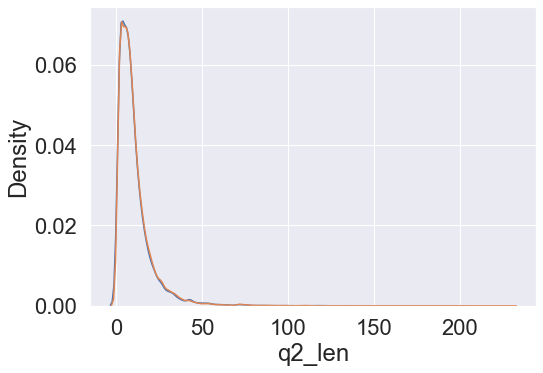

In [25]:
sns.kdeplot(train_df['q2_len'])
sns.kdeplot(test_df['q2_len'])

<AxesSubplot:xlabel='q2_len', ylabel='Density'>

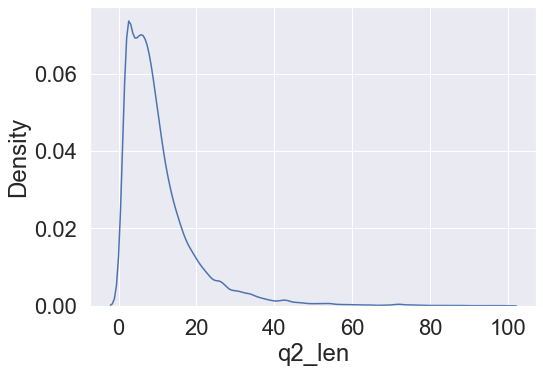

In [26]:
x = df.loc[df["q2_len"]<100]
sns.kdeplot(x['q2_len'])

In [27]:
test_df.head(5)

,id,q1,id_sub,q2,label,q1_len,q2_len
0,0,东区西区？什么时候下证？,0,我在给你发套,NaN,12,6
1,0,东区西区？什么时候下证？,1,您看下我发的这几套,NaN,12,9
2,0,东区西区？什么时候下证？,2,这两套也是金源花园的,NaN,12,10
3,0,东区西区？什么时候下证？,3,价钱低,NaN,12,3
4,0,东区西区？什么时候下证？,4,便宜的房子，一般都是顶楼,NaN,12,12


In [38]:
train_df.to_csv("train_clean.csv",index=False)
test_df.to_csv("test_clean.csv",index=False)